In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os


2023-12-03 23:14:59.105513: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 23:14:59.151372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 23:14:59.151406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 23:14:59.152977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 23:14:59.162075: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf

# Select which GPU to use. Here, we're using GPU 0.
gpu_to_use = 6

# Get a list of physical devices of type 'GPU'
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set TensorFlow to only use the GPU specified by 'gpu_to_use'
        tf.config.experimental.set_visible_devices(gpus[gpu_to_use], 'GPU')

        # This line is optional, it allows TensorFlow to automatically manage
        # GPU memory as needed, instead of allocating all of it at the start.
        tf.config.experimental.set_memory_growth(gpus[gpu_to_use], True)
    except RuntimeError as e:
        # This exception is raised when the visible devices are set after TensorFlow has been initialized.
        print(e)
else:
    print("No GPUs found.")


In [9]:
def get_class_subclass_directories(root_dir, exclude_dir):
    """
    Generates a list of (class, subclass) directory tuples from the root directory,
    excluding the specified directory.
    """
    class_subclass_dirs = []
    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path) and class_dir.lower() != exclude_dir.lower():
            for subclass_dir in os.listdir(class_path):
                subclass_path = os.path.join(class_path, subclass_dir)
                if os.path.isdir(subclass_path):
                    class_subclass_dirs.append((class_dir, subclass_dir))
    return class_subclass_dirs

base_dir = 'Multi-Cancer'
filtered_dirs = get_class_subclass_directories(base_dir, 'all')

# Print out the directories being used
for class_dir, subclass_dir in filtered_dirs:
    print(f"Class: {class_dir}, Subclass: {subclass_dir}")


Class: Oral Cancer, Subclass: train
Class: Oral Cancer, Subclass: val
Class: Oral Cancer, Subclass: test
Class: Oral Cancer, Subclass: oral_scc
Class: Oral Cancer, Subclass: oral_normal
Class: Kidney Cancer, Subclass: val
Class: Kidney Cancer, Subclass: train
Class: Kidney Cancer, Subclass: kidney_tumor
Class: Kidney Cancer, Subclass: kidney_normal
Class: Kidney Cancer, Subclass: test
Class: Brain Cancer, Subclass: brain_tumor
Class: Brain Cancer, Subclass: val
Class: Brain Cancer, Subclass: brain_menin
Class: Brain Cancer, Subclass: test
Class: Brain Cancer, Subclass: train
Class: Brain Cancer, Subclass: brain_glioma


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),  # Adjusted dropout rate

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),  # Adjusted dropout rate

        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.4),  # Adjusted dropout rate

        Dense(num_classes, activation='softmax')
    ])
    adam_optimizer = Adam(learning_rate=0.001)  # Change the learning rate here

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import os
import shutil
import numpy as np

def split_data(base_dir, class_dir, subclass, train_size=0.75, val_size=0.15):
    """
    Split data into training, validation, and testing sets for a given class and subclass.
    """
    # Paths for source and split directories
    source_dir = os.path.join(base_dir, class_dir, subclass)
    train_dir = os.path.join(base_dir, class_dir, 'train', subclass)
    val_dir = os.path.join(base_dir, class_dir, 'val', subclass)
    test_dir = os.path.join(base_dir, class_dir, 'test', subclass)

    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # List all files in the source directory
    files = os.listdir(source_dir)
    np.random.shuffle(files)

    # Split files
    total_files = len(files)
    train_end = int(total_files * train_size)
    val_end = train_end + int(total_files * val_size)

    # Copy files to respective directories
    for i, file in enumerate(files):
        if i < train_end:
            shutil.copy(os.path.join(source_dir, file), train_dir)
        elif i < val_end:
            shutil.copy(os.path.join(source_dir, file), val_dir)
        else:
            shutil.copy(os.path.join(source_dir, file), test_dir)

# Loop through each class-subclass pair
for class_dir, subclass in filtered_dirs:
    print(f"Class: {class_dir}, Subclass: {subclass}")
    split_data(base_dir, class_dir, subclass)


Class: Lymphoma, Subclass: lymph_mcl
Class: Lymphoma, Subclass: lymph_fl
Class: Lymphoma, Subclass: test


IsADirectoryError: [Errno 21] Is a directory: 'Multi-Cancer/Lymphoma/test/lymph_mcl'

In [6]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

def create_generators(base_dir, class_dir, batch_size, target_size=(200, 200)):
    print("Batch size received in create_generators:", batch_size)
    # Rest of the function code
    """
    Create training, validation, and testing generators.
    """
    # Data generator with augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Data generator without augmentation for validation and testing
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Training generator
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, class_dir, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    # Validation generator
    validation_generator = val_test_datagen.flow_from_directory(
        os.path.join(base_dir, class_dir, 'val'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Testing generator
    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(base_dir, class_dir, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Usually, we don't shuffle the test data
    )

    return train_generator, validation_generator, test_generator


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min')
trained = []
def train_model_for_each_class(base_dir, class_subclass_dirs):
    for class_dir, _ in set([(class_dir, _) for class_dir, _ in class_subclass_dirs]):
        
        if(class_dir in trained):
            continue
        trained.append(class_dir)
        print(f"Training model for {class_dir}")

        # Path to the "train" subdirectory for the current class
        train_subdir = os.path.join(base_dir, class_dir, 'train')

        # Determine the number of subclasses in the "train" subdirectory
        if os.path.exists(train_subdir):
            num_classes = len(os.listdir(train_subdir))
        else:
            raise ValueError(f"Train directory for '{class_dir}' not found.")

        # Create a new instance of the model for this class
        model = create_model(num_classes)
        
        # Create data generators for the current class
        train_generator, validation_generator, test_generator = create_generators(base_dir, class_dir, 32)  # Ensure batch_size is an integer
        print("Training Generator - batch size:", train_generator.batch_size, "samples:", train_generator.n)
        print("Validation Generator - batch size:", validation_generator.batch_size, "samples:", validation_generator.n)

        # Train the model
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=50,
            callbacks=[early_stopping, reduce_lr]
        )

        # Save the model
        model_path = f'model_{class_dir}.h5'
        model.save(model_path)

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(test_generator)
        print(f"Test Loss for {class_dir}: {test_loss}")
        print(f"Test Accuracy for {class_dir}: {test_accuracy}")

train_model_for_each_class(base_dir, filtered_dirs)


Training model for Brain Cancer
Batch size received in create_generators: 32
Found 11250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Training Generator - batch size: 32 samples: 11250
Validation Generator - batch size: 32 samples: 2250
Epoch 1/50


2023-12-04 00:26:25.363567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


352/352 [==============================] - 93s 258ms/step - loss: 3.6965 - accuracy: 0.5306 - val_loss: 32.2352 - val_accuracy: 0.5351 - lr: 0.0010
Epoch 2/50
352/352 [==============================] - 101s 286ms/step - loss: 0.9033 - accuracy: 0.5648 - val_loss: 1.0200 - val_accuracy: 0.4893 - lr: 0.0010
Epoch 3/50
352/352 [==============================] - 83s 237ms/step - loss: 0.8652 - accuracy: 0.5760 - val_loss: 1.8653 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 4/50
352/352 [==============================] - 103s 292ms/step - loss: 0.8679 - accuracy: 0.5872 - val_loss: 0.6396 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 5/50
352/352 [==============================] - 102s 288ms/step - loss: 0.8954 - accuracy: 0.5860 - val_loss: 0.9707 - val_accuracy: 0.5769 - lr: 0.0010
Epoch 6/50
352/352 [==============================] - 102s 291ms/step - loss: 0.8393 - accuracy: 0.5976 - val_loss: 0.7002 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 7/50
352/352 [==============================] - 101s

/home/wi223413/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 4s 87ms/step - loss: 0.6191 - accuracy: 0.7687
Test Loss for Brain Cancer: 0.6190612316131592
Test Accuracy for Brain Cancer: 0.768666684627533
Training model for Oral Cancer
Batch size received in create_generators: 32
Found 7500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.
Training Generator - batch size: 32 samples: 7500
Validation Generator - batch size: 32 samples: 1500
Epoch 1/50


2023-12-04 01:18:01.181534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 [==============================] - 74s 306ms/step - loss: 5.2131 - accuracy: 0.5987 - val_loss: 7.4342 - val_accuracy: 0.5220 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - 72s 307ms/step - loss: 0.6116 - accuracy: 0.6420 - val_loss: 10.7189 - val_accuracy: 0.5287 - lr: 0.0010
Epoch 3/50
235/235 [==============================] - 72s 307ms/step - loss: 0.6246 - accuracy: 0.6396 - val_loss: 1.4444 - val_accuracy: 0.5013 - lr: 0.0010
Epoch 4/50
235/235 [==============================] - 70s 299ms/step - loss: 0.6233 - accuracy: 0.6159 - val_loss: 0.6822 - val_accuracy: 0.6353 - lr: 0.0010
Epoch 5/50
235/235 [==============================] - 72s 307ms/step - loss: 0.6064 - accuracy: 0.6384 - val_loss: 0.9222 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 6/50
235/235 [==============================] - 71s 303ms/step - loss: 0.6024 - accuracy: 0.6556 - val_loss: 0.6334 - val_accuracy: 0.6273 - lr: 0.0010
Epoch 7/50
235/235 [==============================] - 74s 313m

2023-12-04 01:49:18.339172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 [==============================] - 69s 285ms/step - loss: 3.7595 - accuracy: 0.5939 - val_loss: 123.8936 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - 70s 296ms/step - loss: 0.5964 - accuracy: 0.6899 - val_loss: 53.7695 - val_accuracy: 0.5393 - lr: 0.0010
Epoch 3/50
235/235 [==============================] - 67s 287ms/step - loss: 0.4968 - accuracy: 0.7396 - val_loss: 2.0521 - val_accuracy: 0.7953 - lr: 0.0010
Epoch 4/50
235/235 [==============================] - 67s 285ms/step - loss: 0.4160 - accuracy: 0.7983 - val_loss: 0.7906 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 5/50
235/235 [==============================] - 70s 298ms/step - loss: 0.3510 - accuracy: 0.8457 - val_loss: 1.1978 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 6/50
235/235 [==============================] - 69s 294ms/step - loss: 0.3104 - accuracy: 0.8585 - val_loss: 3.9030 - val_accuracy: 0.5520 - lr: 0.0010
Epoch 7/50
235/235 [==============================] - 68s 28

In [ ]:
train_model_for_each_class(base_dir, filtered_dirs)


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
from tensorflow.keras.models import load_model

def load_trained_model(model_path):
    return load_model("/TrainedModels/"+model_path)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

ran_test = []
for cancer_type, _ in filtered_dirs:
    if cancer_type in ran_test:
        continue
    ran_test.append(cancer_type)
    print(f"Evaluating model for {cancer_type}")

    # Load the trained model for this cancer type
    model_path = f'model_{cancer_type}.h5'  # Adjust path as needed
    model = load_trained_model(model_path)

    # Load or create test data generator for this cancer type
    _, _, test_generator = create_generators(base_dir, cancer_type, 32)  # Define this function

    # Evaluate the model
    results = model.evaluate(test_generator)
    print(f"Test Loss, Test Accuracy: {results}")

    # Predict on test data
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Generate classification report
    print("Classification Report:\n")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    print("Confusion Matrix:\n")
    print(cm)


Evaluating model for Lymphoma


OSError: No file or directory found at /TrainedModels/model_Lymphoma.h5

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential([
    # Existing Convolutional Layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Replace Flatten with Global Average Pooling
    GlobalAveragePooling2D(),

    # Adjust Dense Layer
    Dense(256, activation='relu'),  # Reduced number of neurons
    BatchNormalization(),
    Dropout(0.5),

    # Output layer remains the same
    Dense(22, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        2

2023-12-02 21:59:10.796026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 76364 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:1c:00.0, compute capability: 8.0
2023-12-02 21:59:10.798263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 62674 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:1f:00.0, compute capability: 8.0
2023-12-02 21:59:10.800244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 53197 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:22:00.0, compute capability: 8.0
2023-12-02 21:59:10.802233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 79086 MB memory:  -> device: 3, name: NVIDIA A100 80GB PCIe, pci bu

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)  # Replace 'test_generator' with your test data generator
print(f"Validation Accuracy: {test_accuracy*100:.2f}%")

# Predict on test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

# Calculate ROC AUC Score
roc_auc = roc_auc_score(true_classes, predictions, multi_class='ovo')  # Use 'ovr' for One-vs-Rest
print(f"ROC AUC Score: {roc_auc:.2f}")

# Generate a classification report
print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n")
print(cm)



344/344 [==============================] - 33s 95ms/step - loss: 0.3049 - accuracy: 0.8980
Validation Accuracy: 89.80%
344/344 [==============================] - 31s 88ms/step
ROC AUC Score: 0.50
Classification Report:

                  precision    recall  f1-score   support

    brain_glioma       0.04      0.04      0.04       500
     brain_menin       0.04      0.05      0.04       500
     brain_tumor       0.04      0.03      0.04       500
   breast_benign       0.05      0.04      0.05       500
breast_malignant       0.04      0.05      0.04       500
      cervix_dyk       0.04      0.04      0.04       500
      cervix_koc       0.04      0.04      0.04       500
      cervix_mep       0.03      0.04      0.03       500
      cervix_pab       0.04      0.04      0.04       500
      cervix_sfi       0.04      0.04      0.04       500
       colon_aca       0.04      0.04      0.04       500
       colon_bnt       0.04      0.04      0.04       500
   kidney_normal       0.

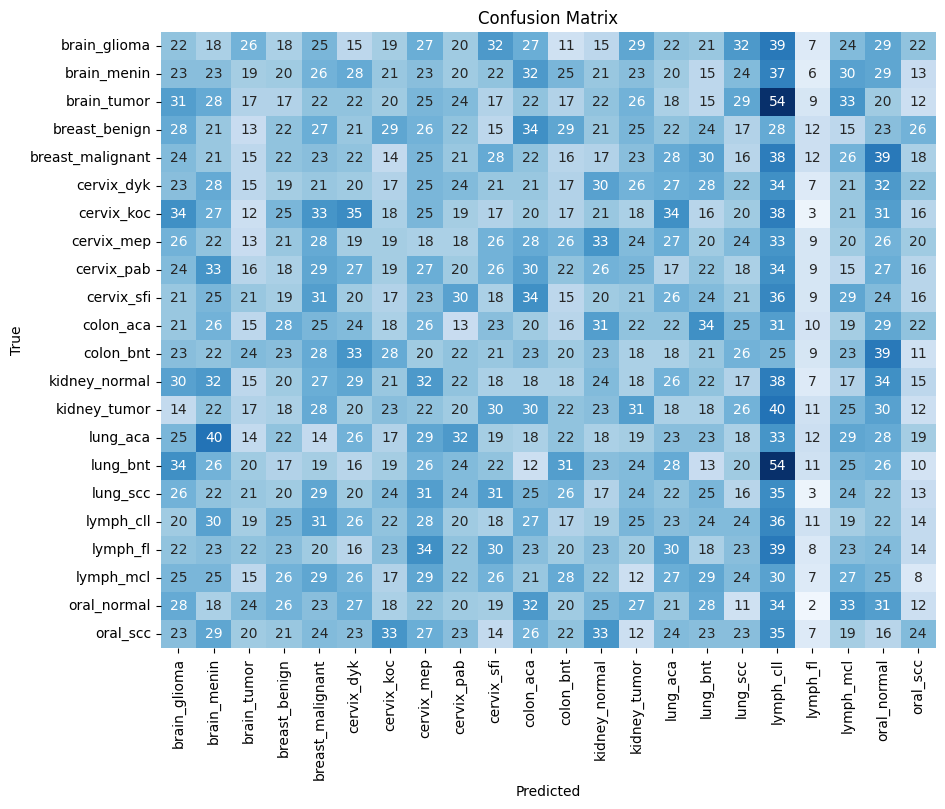

In [ ]:
# Optionally, plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=90)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
